In [1]:
import xarray as xr 
from os.path import join
import os
import matplotlib.pyplot as plt 
import numpy as np
import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython/')

sys.path.append('/home/monte.flora/python_packages/WoF_post')
from monte_python.object_matching import match_to_lsrs, ObjectMatcher
from wofs.verification.lsrs.get_storm_reports import StormReports
from wofs.plotting.util import decompose_file_path
from skimage.measure import regionprops
from glob import glob
from scipy.ndimage import maximum_filter, gaussian_filter, minimum_filter

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

import matplotlib.pyplot as plt 
import matplotlib


import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')
import monte_python

%matplotlib inline

In [2]:
def mask(data):
    return np.ma.masked_where(data==0, data)

In [3]:
def reports_to_grid(ncfile):
    comps = decompose_file_path(ncfile)
    init_time = comps['VALID_DATE']+comps['VALID_TIME']
    report = StormReports(init_time, 
            forecast_length=30,
            err_window=15,             
            )
 
    ds = xr.load_dataset(ncfile)
    grid_ds = report.to_grid(dataset=ds)
    lsr_points = report.get_points(dataset=ds)

    return grid_ds, lsr_points 

In [4]:
def to_matched(data, matched_labels):
    matched = np.zeros(data.shape)
    
    unique_labels = np.unique(data)[1:]
    
    for label in unique_labels:
        if label in matched_labels:
            matched[data==label] = 1.0
        else:
            matched[data==label] = -1.0
    return matched

In [5]:
def label_centroid(x, y, ax, object_props, storm_modes=None, converter=None):
    """Place object label on object's centroid"""
    for region in object_props:
        x_cent,y_cent = region.centroid
        x_cent=int(x_cent)
        y_cent=int(y_cent)
        xx, yy = x[x_cent,y_cent], y[x_cent,y_cent]
        
        if storm_modes is None:
            fontsize = 6.5 if region.label >= 10 else 8
            txt = region.label
        else:
            fontsize=4
            coords = region.coords
            ind = int(np.max(storm_modes[coords[:,0], coords[:,1]]))
            txt = converter[ind] 
          
        ax.text(xx,yy,
                    txt,
                    fontsize=fontsize,
                    ha='center',
                    va='center',
                    color = 'k'
                    )    

def plot_storm_labels(x, y, labels, ax=None, alpha=1.0):
    """ Plot Storm Labels """
    if ax is None:
        f, ax = plt.subplots(figsize=(5, 4), dpi=150, facecolor='w', edgecolor='k')
    
    label_props = regionprops(labels, labels)
    
    labels = np.ma.masked_where(labels==0, labels)
    c = ax.pcolormesh(x, y, labels, cmap='tab20', vmin=1, vmax=np.max(labels), alpha=alpha, shading='auto')
    ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(alpha=0.5, ls='dashed')
    
    label_centroid(x, y, ax, label_props) 
    
    return ax

In [6]:
def new_id(input_data, remove_low=True):
    
    param_set = [ {'min_thresh': 0,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 800,
                   'dist_btw_objects': 125 },
             
             {'min_thresh': 30,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 400,
                   'dist_btw_objects': 30 },
                 
             {'min_thresh': 50,
                   'max_thresh': 100,
                   'data_increment': 1,
                   'delta': 0,
                   'area_threshold': 250,
                   'dist_btw_objects': 25 },    
                 
            ]

    params = {'params': param_set }

    # Less than 2/18 = 0.11, 1/18 = 0.055
    new_input_data = np.copy(input_data)
    #if remove_low:
    #    new_input_data[input_data<=0.12] = 0

    new_input_data = maximum_filter(new_input_data, size=4)
    if remove_low:
        new_input_data[input_data<=0.12] = 0
    
    new_input_data = gaussian_filter(new_input_data, 1.5)*100

    storm_labels, new_object_props = monte_python.label(  input_data = new_input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    
    # Reduce the object size due to the maximum filter and gaussian filter 
    idx = np.where(input_data==0)
    storm_labels[idx] = 0
    
    #storm_labels = minimum_filter(storm_labels, size=3)
    new_object_props = regionprops(storm_labels, storm_labels)
    
    return storm_labels, new_input_data, new_object_props

For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...
For 2021 dataset, loading local storm reports...


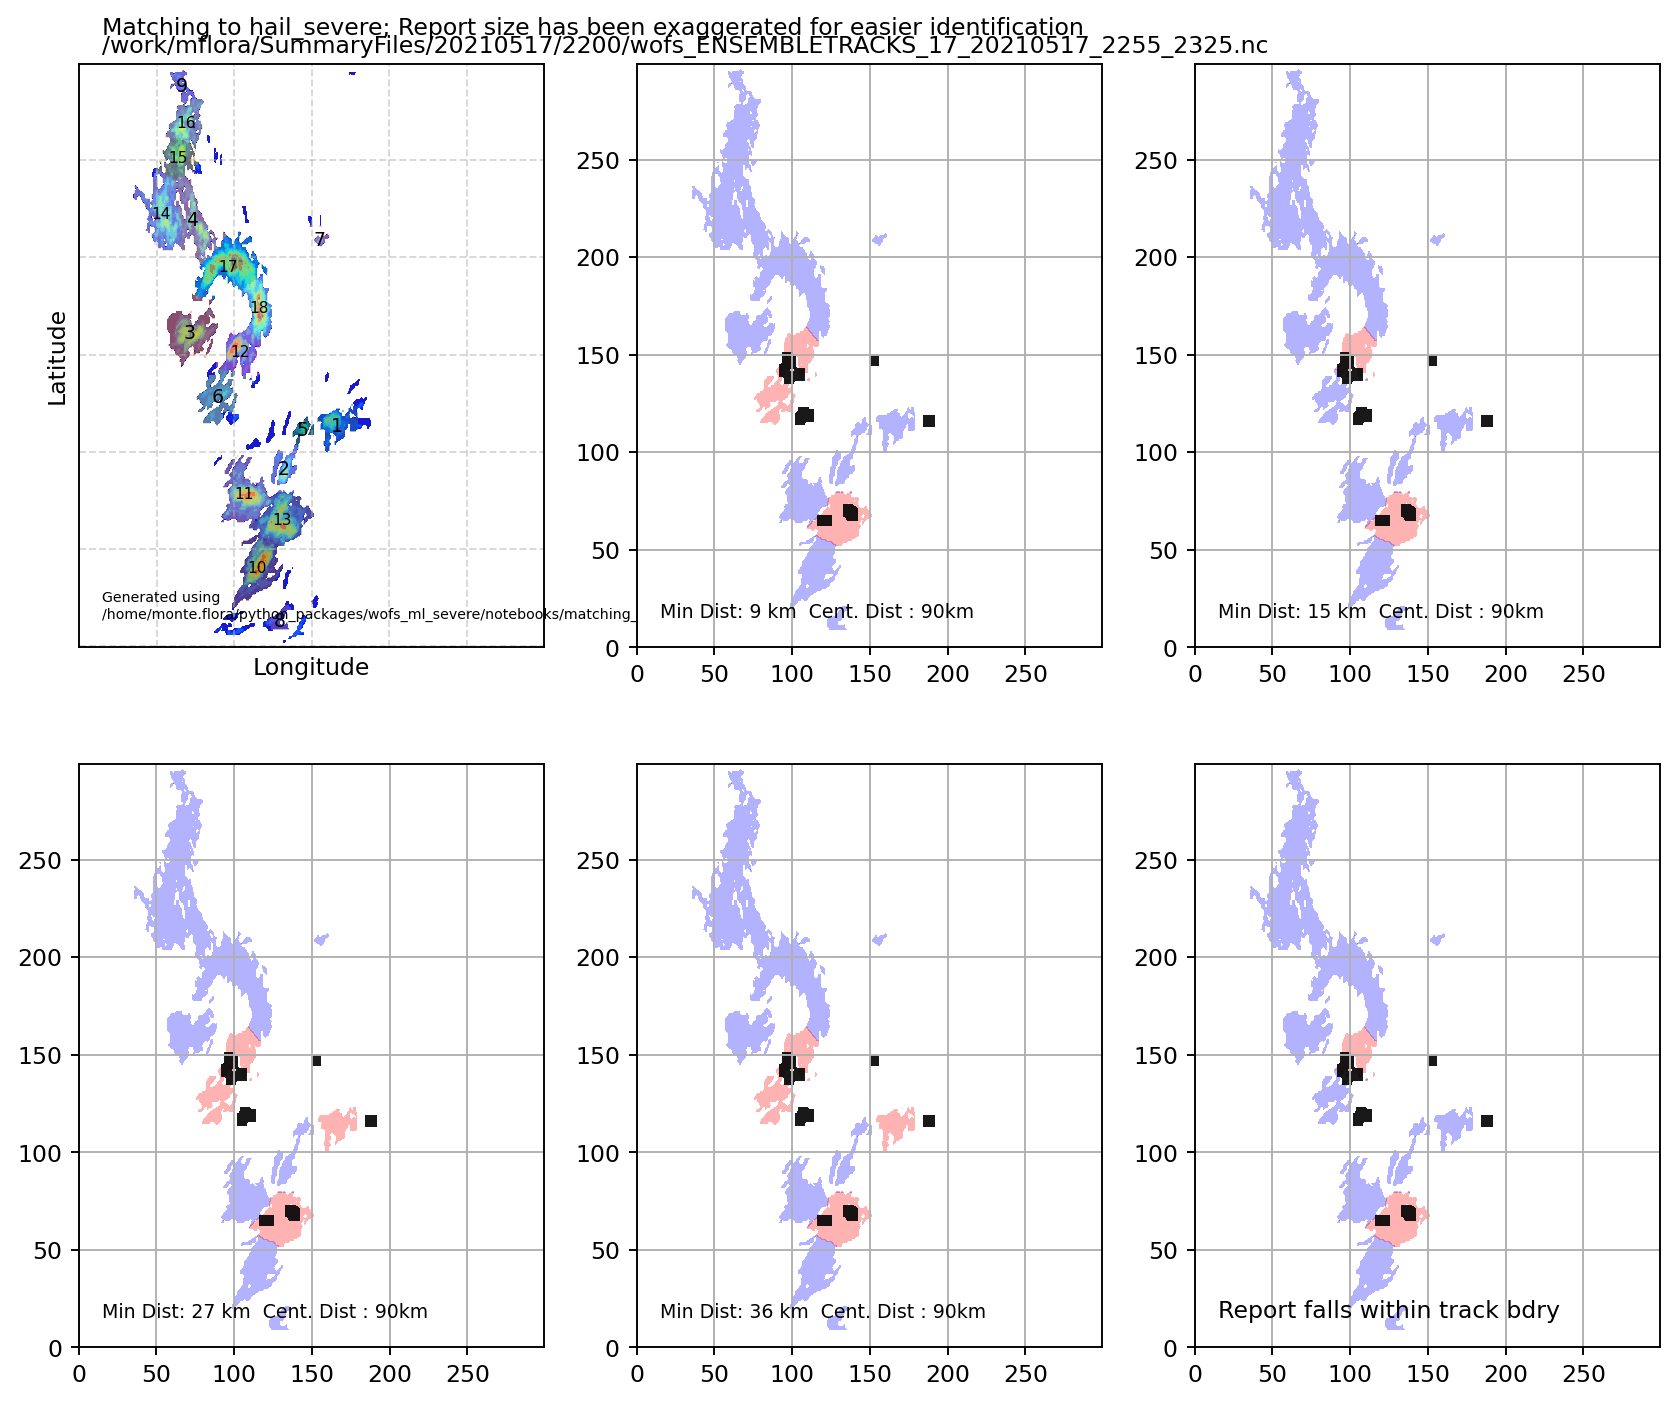

In [7]:
def animate(i):
    fname = fnames[i]
    for ax in axes.flat:
        ax.clear()
    
    # Adding metadata to the plot. 
    axes[0,0].annotate(f'Matching to {var}; Report size has been exaggerated for easier identification',
                    (0.05, 1.05), xycoords='axes fraction')
    
    axes[0,0].annotate(fname,
                    (0.05, 1.02), xycoords='axes fraction')
    
    axes[0,0].annotate(f'Generated using\n{os.getcwd()}/matching_to_storm_reports.ipynb',
                    (0.05, 0.05), xycoords='axes fraction', fontsize=6)
    
    # Load the ensemble tracks and the probs the tracks were generated from.
    ds = xr.load_dataset(fname)
    
    tracks = ds['w_up__ensemble_tracks'].values
    probs = ds['w_up__ensemble_probabilities'].values
    
    tracks,_,_ = new_id(probs)
    
    labels = np.unique(tracks)[1:]
    storm_data_ds, lsr_points = reports_to_grid(fname)

    target = storm_data_ds[var].values
    reports = mask(storm_data_ds[var])
    reports[reports>0] = 1
    
    # Perform different object matching.
    matched_tracks_set=[]
    #dists = [10, 15, 20, 30]
    
    # 9 , 15, 27, 36
    dists = [3,5,9,12]
    for dist in dists:
        obj_match = ObjectMatcher(min_dist_max=dist,
                                      cent_dist_max=cent_dist,
                                      time_max=0,
                                      score_thresh = 0.2,
                                      one_to_one = False, 
                                     match_to_reports=True)

        matched_tracks, _, _ = obj_match.match(object_set_a=tracks, object_set_b=target, input_a=probs)
        matched_arr = to_matched(tracks, matched_tracks)
        matched_tracks_set.append(matched_arr)
    
    # Matching based on if the report falls within the track (like the original paper).
    object_props = regionprops(tracks, tracks)    
    match_dict = match_to_lsrs(object_props, lsr_points[var], dist_to_lsr=1)

    matched_tracks = [l for l in labels if match_dict[l] == 1.0]
    
    matched_arr = to_matched(tracks, matched_tracks)
    matched_tracks_set.append(matched_arr)
    
    x,y = np.meshgrid(np.arange(len(tracks)), np.arange(len(tracks)))
    
    # Upper left hand. Ensemble storm tracks and the underlying probs. 
    axes[0,0].contourf(x,y,mask(probs), cmap='jet', alpha=0.9)
    plot_storm_labels(x,y,tracks, ax=axes[0,0], alpha=0.5)   
    
    # Upper right hand.
    for i, (ax, data) in enumerate(zip(axes.flat[1:], matched_tracks_set)):
        if i < 4:
            #ax.annotate(f'Min Dist: {dists[i]*3} km, Cent Dist: {cent_dist*3} km',
            #        (0.05, 0.05), xycoords='axes fraction', fontsize=7)
            ax.annotate(f'Min Dist: {dists[i]*3} km  Cent. Dist : {cent_dist*3}km',
                    (0.05, 0.05), xycoords='axes fraction', fontsize=8)
            
        else:
            ax.annotate(f'Report falls within track bdry',
                    (0.05, 0.05), xycoords='axes fraction')
        ax.contourf(x, y, mask(data), cmap='seismic', levels=[-1,0,1], alpha=0.3) 
        ax.contourf(x, y, mask(maximum_filter(reports,5)), colors='k', alpha=0.9) 
        #ax.set_xlim([175, 250])
        #ax.set_ylim([50, 100])
        ax.grid()
    
    
fig, axes = plt.subplots(dpi=170, figsize=(12,10), ncols=3, nrows=2)

# 20210526, 20210513, 20210504, 20210517, 20180502 (torn), 20180518 (torn), 20200507 (hail)
# 20200504 (hail)

date = '20210517'
init_time = '2200'
save_gif = False
var = 'hail_severe'

cent_dist = 30
colors = {'wind_severe' : 'b', 'hail_severe' : 'g', 'tornado_severe' : 'r'}
path = f'/work/mflora/SummaryFiles/{date}/{init_time}'
fnames = glob(join(path, 'wofs_ENSEMBLETRACKS_*'))

fnames.sort()
fnames = fnames[:12]
    
# call the animator. blit=True means only re-draw the parts that have changed.
#plt.tight_layout()
anim = FuncAnimation(fig, animate, frames=len(fnames), interval=200, repeat=True, blit=False)
HTML(anim.to_jshtml())
#anim.save(f'matched_to_reports_{date}_{init_time}_{var}.gif', writer='pillow', fps=5)